In [2]:
import qiskit
from qiskit.providers import BaseBackend
from qiskit.providers.ibmq import IBMQBackend

In [3]:
from dc_qiskit_qml.feature_maps import NormedAmplitudeEncoding
from dc_qiskit_qml.distance_based.hadamard import QmlHadamardNeighborClassifier
from dc_qiskit_qml.distance_based.hadamard.state import QmlGenericStateCircuitBuilder
from dc_qiskit_qml.distance_based.hadamard.state.sparsevector import MöttönenStatePreparation

initial_state_builder = QmlGenericStateCircuitBuilder(MöttönenStatePreparation())

execution_backend: BaseBackend = qiskit.Aer.get_backend('qasm_simulator')
qml = QmlHadamardNeighborClassifier(backend=execution_backend,
                                    shots=8192, 
                                    classifier_circuit_factory=initial_state_builder,
                                    feature_map=NormedAmplitudeEncoding())

In [4]:
import numpy as np

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris

X, y = load_iris(True)
X = np.asarray([x[0:2] for x, y in zip(X, y) if y != 2])
y = np.asarray([y for x, y in zip(X, y) if y != 2])

X_train = X[[33, 85]]
y_train = y[[33, 85]]

X_test = X[[28, 36]]
y_test = y[[28, 36]]

In [5]:
pipeline = Pipeline([
    ('scaler',  StandardScaler()), 
    ('l2norm', Normalizer(norm='l2', copy=True)),
    ('qml', qml)
])

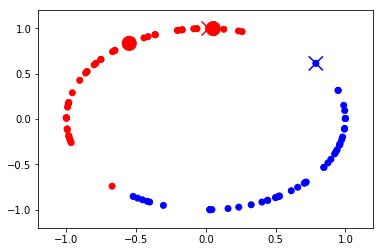

In [9]:
import matplotlib.pyplot as plt

_X = pipeline.fit_transform(X, y)
_X_train = pipeline.transform(X_train)
_X_test = pipeline.transform(X_test)


plt.scatter(
    _X[:,0], _X[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y])
plt.scatter(
    _X_train[:,0], _X_train[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_train],
    marker='x', s=200)
plt.scatter(
    _X_test[:,0], _X_test[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_test],
    marker='o', s=200)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.show()

In [12]:
pipeline.fit(X_train, y_train)
pipeline.predict(X_test), y_test

([0, 0], array([0, 0]))

In [13]:
qml._last_predict_circuits[0].draw(line_length=120)

# Now a lot more data

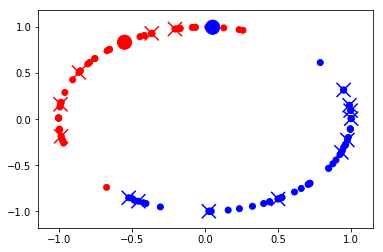

In [15]:
X_train = X[45:60]
y_train = y[45:60]

X_test = X[[33, 90]]
y_test = y[[33, 90]]

_X = pipeline.fit_transform(X, y)
_X_train = pipeline.transform(X_train)
_X_tests = pipeline.transform(X_test)

plt.scatter(
    _X[:,0], _X[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y])
plt.scatter(
    _X_train[:,0], _X_train[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_train],
    marker='x', s=200)
plt.scatter(
    _X_test[:,0], _X_test[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_test],
    marker='o', s=200)
plt.show()

In [16]:
pipeline.fit(X_train, y_train)
pipeline.predict(X_test), y_test

([0, 1], array([0, 1]))

In [17]:
qml._last_predict_circuits[0].draw(line_length=120)

In [18]:
print(qml._last_predict_circuits[0].qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg a[1];
qreg i[4];
qreg f^S[1];
qreg l^q[1];
creg l^c[1];
creg b[1];
ry(1.91063323624902) l^q[0];
cx l^q[0],f^S[0];
ry(-0.00154681278594682) f^S[0];
cx l^q[0],f^S[0];
ry(2.00723234257407) f^S[0];
cx l^q[0],i[3];
ry(-0.937876871024607) i[3];
cx f^S[0],i[3];
ry(0.139415767012160) i[3];
cx l^q[0],i[3];
ry(-0.139415767012160) i[3];
cx f^S[0],i[3];
ry(0.937876871024607) i[3];
cx l^q[0],i[2];
ry(-0.924291663253532) i[2];
cx i[3],i[2];
ry(-0.169916059006697) i[2];
cx f^S[0],i[2];
ry(0.0515315674837591) i[2];
cx i[3],i[2];
ry(-0.0193314851765009) i[2];
cx l^q[0],i[2];
ry(0.0515315674837591) i[2];
cx i[3],i[2];
ry(-0.0193314851765009) i[2];
cx f^S[0],i[2];
ry(0.646504663541365) i[2];
cx i[3],i[2];
ry(1.40088026778820) i[2];
cx l^q[0],i[1];
ry(-0.379632742312379) i[1];
cx i[2],i[1];
ry(0.387927188154626) i[1];
cx i[3],i[1];
ry(0.478317806127522) i[1];
cx i[2],i[1];
ry(0.291055007623457) i[1];
cx f^S[0],i[1];
ry(-0.0294575544686851) i[1];
cx i[2],i[1];
ry(0.